In [1]:
import csv
import sklearn
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from tensorflow.keras.utils import (
    Sequence,
)  # needed if more than one feature is fed into model

import os, sys


# Set up the Project Path
# Add this line to your ~/.bashrc or ~/.zshrc: export REALTIMEID_PATH='/absolute/path/to/project'
project_path = os.environ.get('MLSTOCKS_PATH')
if project_path and project_path not in sys.path:
    sys.path.append(project_path)
    print("Project path successfully added.")
else:
    print("Warning: 'MLSTOCKS_PATH' environment variable is not set.")


from src.preprocess.preprocess import StockPricePreprocessor
from src.stock_sequence.stock_sequence import StockSequence

2024-01-01 18:02:46.935023: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/julianthoenniss/Documents/fML/ML-StockAnalysis/.venv/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Project path successfully added.


In [2]:
# Download using yfinance
nasdaq_100 = yf.download(tickers="qqq", period="max", interval="1d")
google = yf.download(tickers="GOOGL", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# preprocess data for stock and index:
# get closing data as Panda series:
google_close = google["Close"].values
google_vols = google["Volume"].values
# read closing dates only from starting date of Google onwards
nasdaq_100_close = nasdaq_100["Close"][-len(google_close) :].values

assert len(google_close) == len(google_vols) and len(google_close) == len(nasdaq_100_close), "Lenghts of data arrays not compatible."
preprocessor = StockPricePreprocessor()

google_close_training_scaled, google_close_test_scaled = preprocessor.pre_process_maxmin(prices=google_close, feature_name="google_close")
google_vols_training_scaled, google_vols_test_scaled = preprocessor.pre_process_maxmin(prices=google_vols, feature_name="google_vols")
nasdaq_100_training_scaled, nasdaq_100_test_scaled = preprocessor.pre_process_maxmin(prices=nasdaq_100_close, feature_name="nasdaq_100_close")


In [4]:
# Sequence generation
sequence_length = 10  # Length of input sequences
batch_size = 32

# Generate input sequences
training_data = StockSequence(
    google_close_training_scaled, google_vols_training_scaled, nasdaq_100_training_scaled, batch_size, sequence_length
)

In [5]:
#Extract number of features from entered data
series_first_sequence = training_data[0]["sequence_with_features"] #first index: sequence index, second index: "sequence_with_features" (one for each feature) or "target" 
#series_first_sequence is 2D array with shape (sequence_length, nbr_features)
nbr_features = series_first_sequence.shape[1] 
print(f"Number of features: {nbr_features}")

Number of features: 3


In [6]:
# Define the model architecture
model = Sequential()

# for sequential model:
#nbr_features = 1
#input_data = np.array([training_data[i][0][:,0] for i in range (len(training_data))])#pure price input data
#model.add(Dense(64, activation='relu',input_shape=(sequence_length,)))


# for LSTM:
input_data = np.array([data["sequence_with_features"] for data in training_data])#input data with 3 features
model.add(LSTM(64, activation="relu", input_shape=(sequence_length,nbr_features), return_sequences=True))#
model.add(LSTM(64, activation="relu", input_shape=(sequence_length,nbr_features), return_sequences=False))

model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))  # Output layer with 1 neuron for regression

# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model
target_data = np.array([data["target"] for data in training_data])#target data

model.fit(input_data, target_data, epochs=10, batch_size=32)

Epoch 1/10
122/122 [==============================] - 4s 7ms/step - loss: 0.0087
Epoch 2/10
122/122 [==============================] - 1s 6ms/step - loss: 2.4356e-04
Epoch 3/10
122/122 [==============================] - 1s 7ms/step - loss: 1.6340e-04
Epoch 4/10
122/122 [==============================] - 1s 7ms/step - loss: 1.5489e-04
Epoch 5/10
122/122 [==============================] - 1s 7ms/step - loss: 1.8510e-04
Epoch 6/10
122/122 [==============================] - 1s 6ms/step - loss: 1.6869e-04
Epoch 7/10
122/122 [==============================] - 1s 6ms/step - loss: 1.6910e-04
Epoch 8/10
122/122 [==============================] - 1s 6ms/step - loss: 1.7002e-04
Epoch 9/10
122/122 [==============================] - 1s 6ms/step - loss: 1.4708e-04
Epoch 10/10
122/122 [==============================] - 1s 6ms/step - loss: 1.5300e-04


In [7]:
# Perform predictions
# Generate input sequences
test_data_scaled = StockSequence(
    google_close_test_scaled, google_vols_test_scaled, nasdaq_100_test_scaled, batch_size, sequence_length
)


#test_data_pure_price = np.array([data[0][:,0] for data in test_data])
#predictions = model.predict(test_data_pure_price)

test_data_scaled_with_features = np.array([data["sequence_with_features"] for data in test_data_scaled])


predictions_raw = model.predict(test_data_scaled_with_features)

print(predictions_raw.shape)
#convert to non-rescaled values:
# Reshaping predictions to a 2D array if they are 1D
predictions_reshaped = predictions_raw.reshape(-1, 1)

# Rescaling the predictions back to their original scale
predictions = preprocessor.inverse_transform(scaled_data = predictions_reshaped, feature_name="google_close")


test_targets = google_close[preprocessor.split_index + sequence_length:]


assert len(test_targets) == len(
    predictions
), f"Predictions and actual data have different length:, {len(predictions), len(test_targets)}" 
# Evaluate the performance
# Calculate the mean squared error (MSE)
predictions = predictions.ravel()



mse = np.mean((test_targets - predictions) ** 2)
# Calculate the mean absolute error (MAE)
mae = np.mean(np.abs(test_targets - predictions))



31/31 [==============================] - 0s 2ms/step
(965, 1)


Mean squared error:  42.68951330740406
Mean absolute error:  5.252987884363362


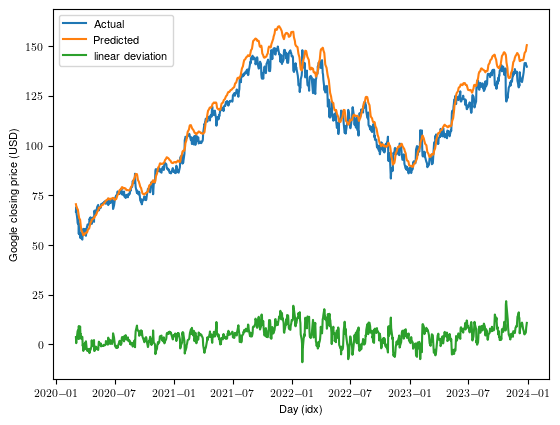

In [8]:
# Visualize the results

#Set global plot parameters
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})

fig, (ax1) = plt.subplots(1)

dates_array = google.index.to_numpy()[-len(predictions):]
ax1.plot(dates_array, test_targets, label="Actual")
ax1.plot(dates_array,predictions, label="Predicted")
ax1.plot(dates_array,(predictions-test_targets), label="linear deviation")
#ax1.plot(((predictions-test_targets)**2), label="square deviation")
ax1.legend()

ax1.set_xlabel("Day (idx)")
ax1.set_ylabel("Google closing price (USD)")

#ax1.set_ylim(top = 1.1* np.max(predictions))
print("Mean squared error: ", mse)
print("Mean absolute error: ", mae)
# ax2.plot(mse, label='Mean Squared Error')
# ax2.legend()

#plt.show()